# HTTP Payload Anomaly Detection with Attention Mechanism (Bahdanau)



# Cell 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Bidirectional
from tensorflow.keras.layers import AdditiveAttention, LayerNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

plt.style.use('ggplot')

In [2]:
!unzip /content/HTTP.zip

Archive:  /content/HTTP.zip
  inflating: Test_data.csv           
  inflating: Train_data.csv          


# Cell 2: Load and Explore Data

Dataset shape: (25192, 42)

First 5 rows:


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


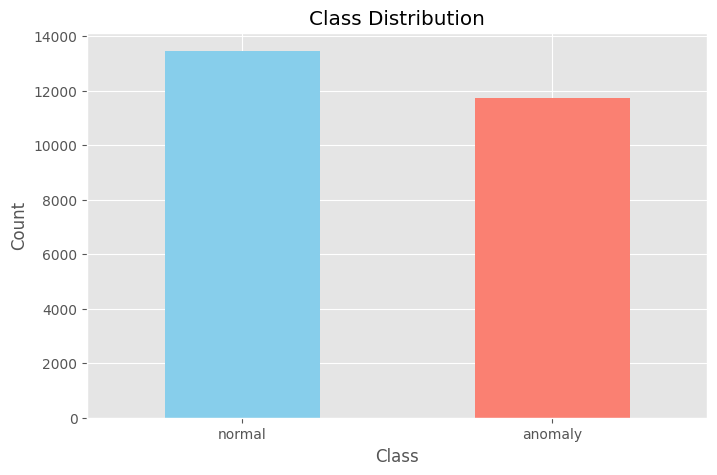


HTTP traffic shape: (8003, 42)


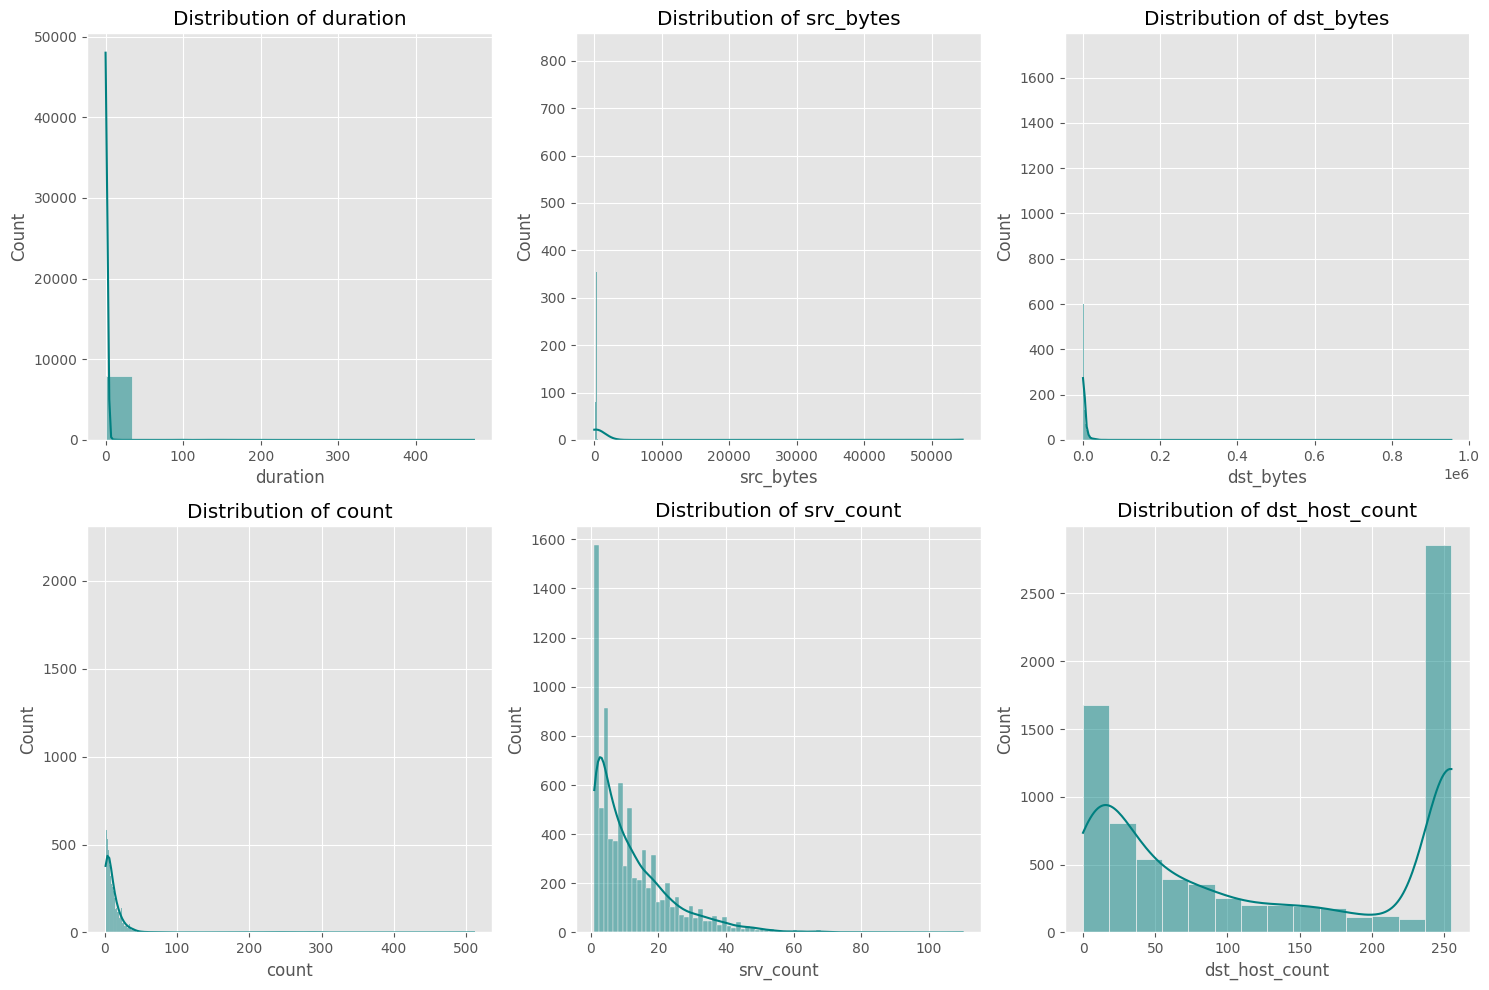

In [3]:

data = pd.read_csv('/content/Train_data.csv')
print("Dataset shape:", data.shape)
print("\nFirst 5 rows:")
display(data.head())

# Plot class distribution
plt.figure(figsize=(8, 5))
data['class'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# HTTP traffic only
http_data = data[data['service'] == 'http'].copy()
print("\nHTTP traffic shape:", http_data.shape)

# Selected features
features = [
    'duration', 'src_bytes', 'dst_bytes', 'count', 'srv_count',
    'dst_host_count', 'dst_host_srv_count', 'same_srv_rate',
    'diff_srv_rate', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate'
]

# Plot feature distributions
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features[:6]):  # Plot first 6 features
    plt.subplot(2, 3, i+1)
    sns.histplot(http_data[feature], kde=True, color='teal')
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

# Cell 3: Preprocess Data

In [4]:

# Encode target
label_encoder = LabelEncoder()
http_data['class_encoded'] = label_encoder.fit_transform(http_data['class'])

# Normalize features
scaler = MinMaxScaler()
http_data[features] = scaler.fit_transform(http_data[features])

# Create sequences
def create_sequences(data, sequence_length=10):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        label = data.iloc[i+sequence_length-1]['class_encoded']
        sequences.append(seq[features].values)
        labels.append(label)
    return np.array(sequences), np.array(labels)

X, y = create_sequences(http_data)
y = to_categorical(y, num_classes=2)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (6394, 10, 17)
Test data shape: (1599, 10, 17)


# Cell 4: Model Architecture

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10, 17)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ [(None, 10, 128), │     41,984 │ input_layer[0][0] │
│ (Bidirectional)     │ (None, 64),       │            │                   │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 128)    │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ additive_attention  │ (None, 10, 128)   │        128 │ bidirectional[0]… │
│ (AdditiveAttention) │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 10, 128)   │          0 │ additive_attenti… │
│                     │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128)       │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 256)       │          0 │ lambda[0][0],     │
│ (Concatenate)       │                   │            │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     16,448 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2)         │        130 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 58,690 (229.26 KB)

 Trainable params: 58,690 (229.26 KB)

 Non-trainable params: 0 (0.00 B)

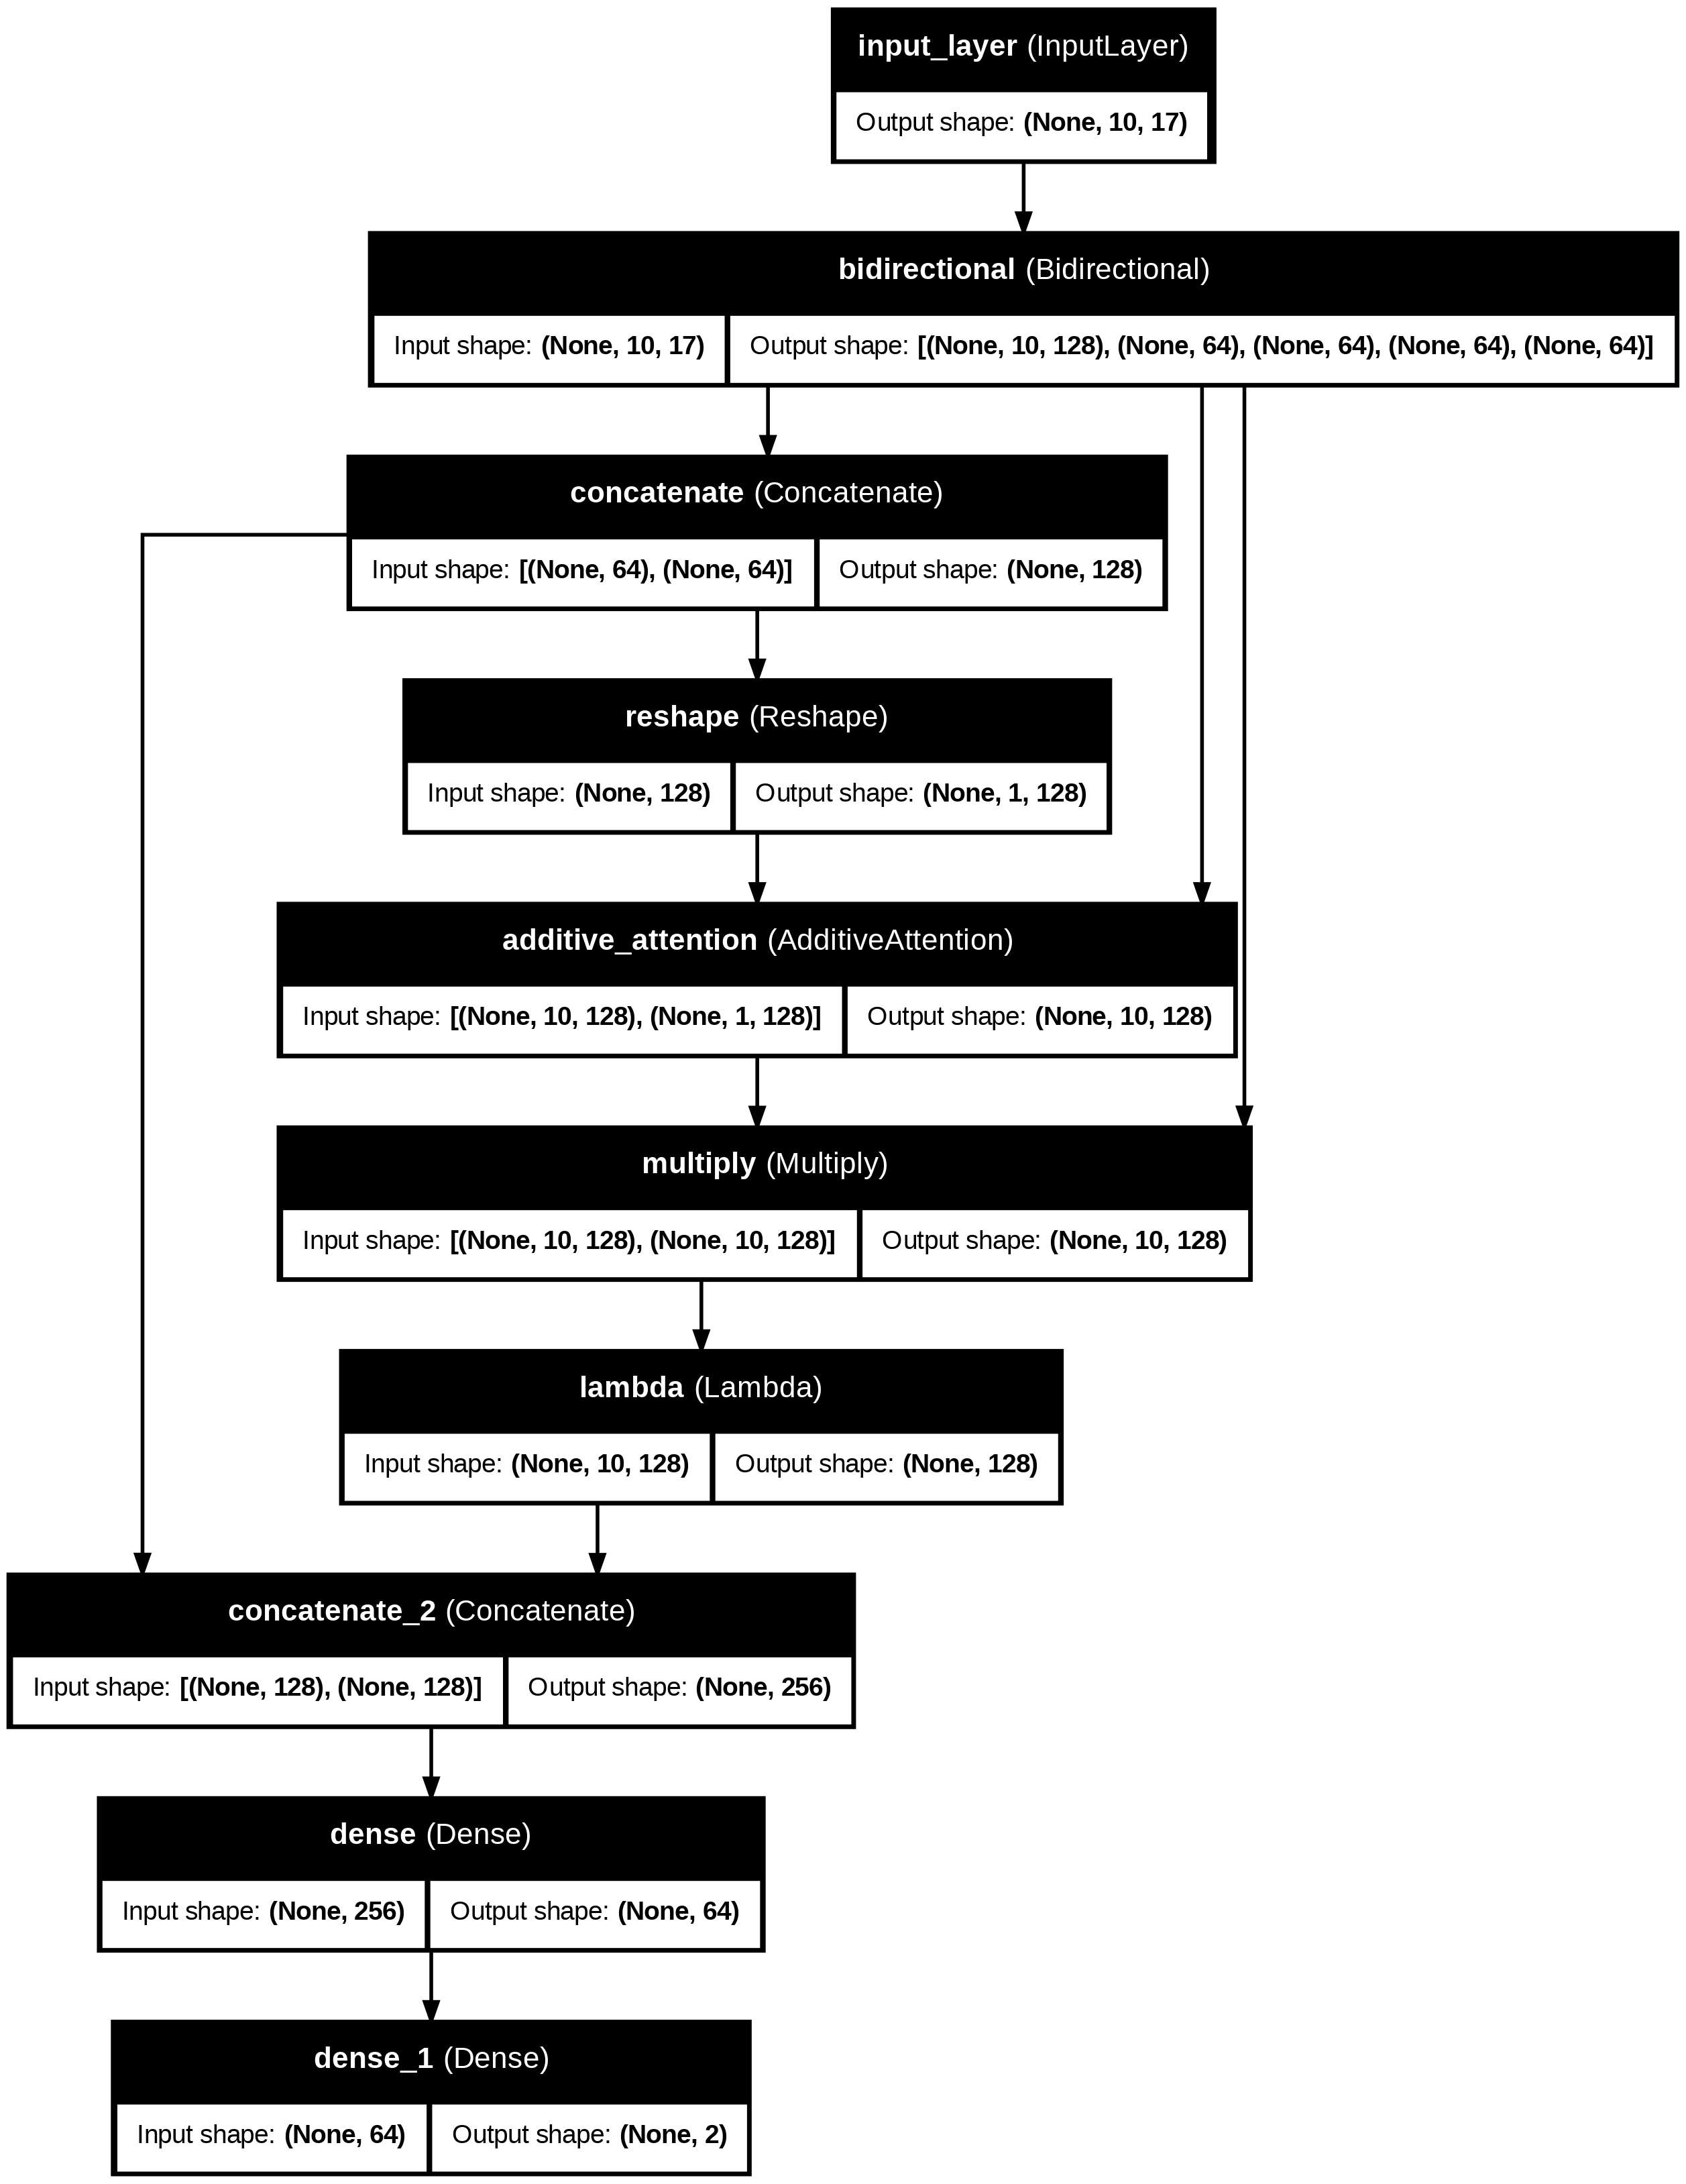

In [5]:
# First, import the required decorator at the top of your notebook
from keras.saving import register_keras_serializable

# Then modify the reduce_sum_layer function to be serializable
@register_keras_serializable()
def reduce_sum_layer(x):
    return tf.reduce_sum(x, axis=1)

# Now the complete fixed Cell 4 should look like:
from tensorflow.keras.layers import Reshape, Multiply, Lambda
from keras.saving import register_keras_serializable

input_dim = X_train.shape[2]
sequence_length = X_train.shape[1]
output_dim = y_train.shape[1]
latent_dim = 64

# Registered custom layer function
@register_keras_serializable()
def reduce_sum_layer(x):
    return tf.reduce_sum(x, axis=1)

# Encoder
encoder_inputs = Input(shape=(sequence_length, input_dim))
encoder = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)

# Concatenate states
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

# Prepare query
query = Reshape((1, latent_dim*2))(state_h)

# Attention mechanism
attention = AdditiveAttention()([encoder_outputs, query])

# Context vector
context_vector = Multiply()([attention, encoder_outputs])
context_vector = Lambda(reduce_sum_layer,
                       output_shape=(latent_dim*2,))(context_vector)

# Decoder
decoder_input = Concatenate()([context_vector, state_h])
decoder_output = Dense(latent_dim, activation='tanh')(decoder_input)
output = Dense(output_dim, activation='softmax')(decoder_output)

model = Model(encoder_inputs, output)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

# Cell 5: Train the Model (Fixed)

In [6]:

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
]

history = model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=callbacks
)

# Load best model
best_model = tf.keras.models.load_model('best_model.h5')

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 10, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9376 - loss: 0.2381

100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.9378 - loss: 0.2368 - val_accuracy: 0.9725 - val_loss: 0.0608
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9921 - loss: 0.0293

100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9921 - loss: 0.0292 - val_accuracy: 0.9987 - val_loss: 0.0069
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9989 - loss: 0.0045 - val_accuracy: 0.9975 - val_loss: 0.0102
Epoch 4/50
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9980 - loss: 0.0054

100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9980 - loss: 0.0054 - val_accuracy: 0.9981 - val_loss: 0.0043
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9996 - loss: 0.0029 - val_accuracy: 0.9987 - val_loss: 0.0068
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9993 - loss: 0.0030

100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9993 - loss: 0.0030 - val_accuracy: 1.0000 - val_loss: 0.0032
Epoch 7/50
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9998 - loss: 0.0021

100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9998 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9987 - loss: 0.0051 - val_accuracy: 1.0000 - val_loss: 0.0018
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9995 - loss: 0.0051

100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9995 - loss: 0.0051 - val_accuracy: 0.9987 - val_loss: 0.0013
Epoch 10/50
 98/100 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9992 - loss: 0.0048

100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9992 - loss: 0.0048 - val_accuracy: 1.0000 - val_loss: 9.7274e-04
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9998 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9994 - loss: 0.0053 - val_accuracy: 0.9987 - val_loss: 0.0017
Epoch 13/50
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9997 - loss: 0.0017

100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9997 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 8.0279e-04
Epoch 14/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9996 - loss: 0.0036 - val_accuracy: 0.9987 - val_loss: 0.0014
Epoch 15/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9998 - loss: 0.0018 - val_accuracy: 0.9994 - val_loss: 0.0015
Epoch 16/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9999 - loss: 0.0011 - val_accuracy: 0.9987 - val_loss: 0.0029
Epoch 17/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9995 - loss: 0.0044 - val_accuracy: 0.9994 - val_loss: 0.0012
Epoch 18/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9998 - loss: 0.0014 - val_accuracy: 0.9994 - val_loss: 0.0018


# Cell 6: Training Visualization

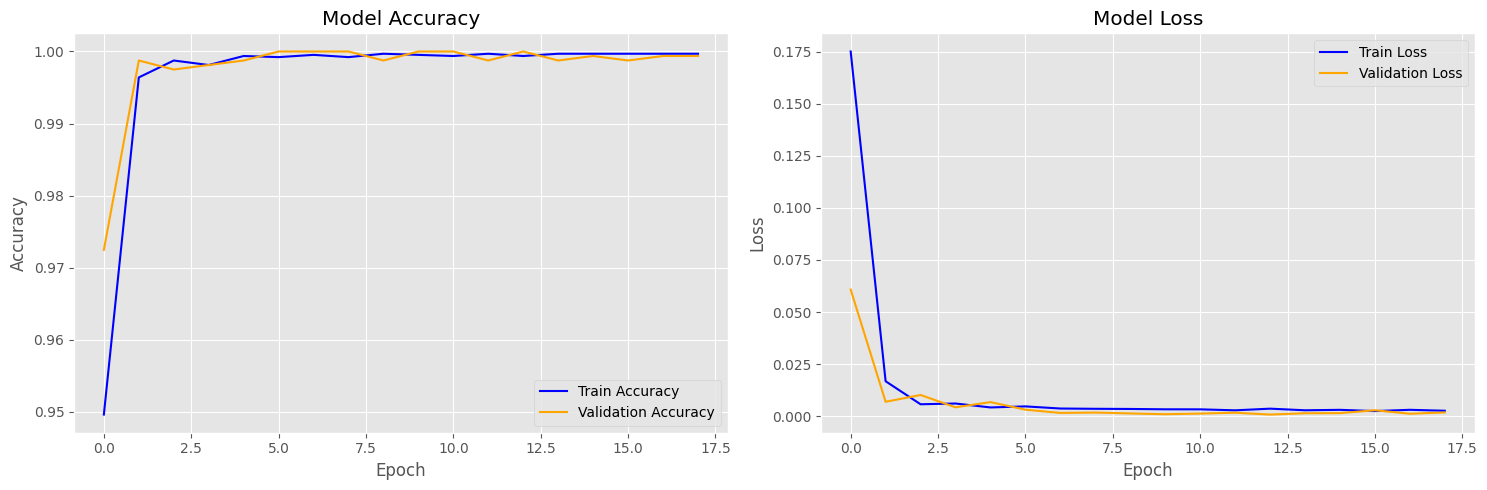

In [7]:

plt.figure(figsize=(15, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# Cell 7: Model Evaluation

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 7.9685e-04
Test Accuracy: 100.00%
14/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step   

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 10, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


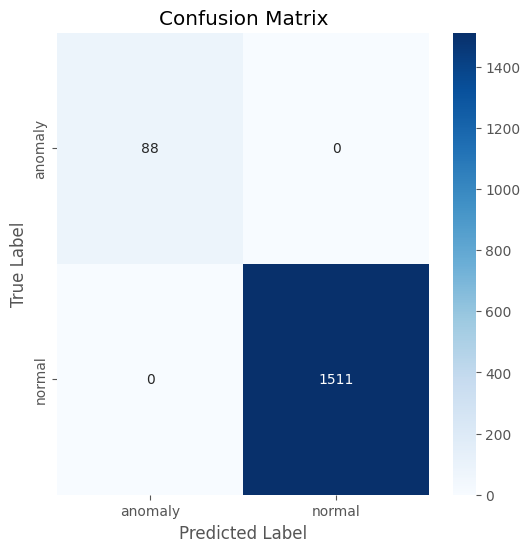


Classification Report:
              precision    recall  f1-score   support

     anomaly       1.00      1.00      1.00        88
      normal       1.00      1.00      1.00      1511

    accuracy                           1.00      1599
   macro avg       1.00      1.00      1.00      1599
weighted avg       1.00      1.00      1.00      1599



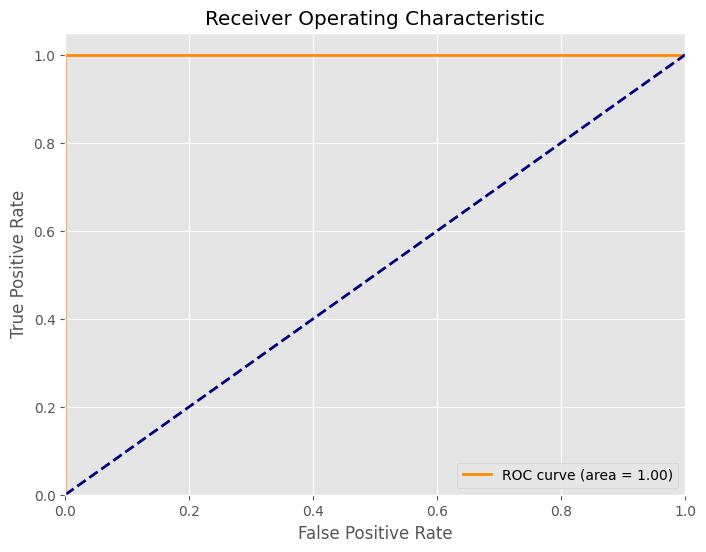

In [8]:

loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

# Predictions
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [9]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=f159e39d64b3dbeef2698129170f01f52f8519602e3ac076ec78fb03cda1c962
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [14]:
# BLEU and ROUGE Evaluation for Sequence Labels
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from sklearn.metrics import classification_report
import numpy as np

# Flatten predictions
y_pred_flat = np.ravel(y_pred[:, 1])  # assuming y_pred is softmax or sigmoid output with 2 columns

# Convert numeric labels to text labels
ref_labels = ["normal" if y == 0 else "anomaly" for y in y_true]
pred_labels = ["anomaly" if p > 0.5 else "normal" for p in y_pred_flat]

# BLEU Score with smoothing
smoothie = SmoothingFunction().method4
bleu = corpus_bleu([[ref.split()] for ref in ref_labels],
                   [pred.split() for pred in pred_labels],
                   smoothing_function=smoothie)
print(f"\nBLEU Score (with smoothing): {bleu:.4f}")

# ROUGE Score
ref_text = " ".join(ref_labels)
pred_text = " ".join(pred_labels)
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
rouge = scorer.score(ref_text, pred_text)
print(f"ROUGE-1: {rouge['rouge1']}")
print(f"ROUGE-L: {rouge['rougeL']}")

# Optional: Print classification report
print("\nClassification Report:")
print(classification_report(ref_labels, pred_labels, target_names=["normal", "anomaly"]))



BLEU Score (with smoothing): 0.0019
ROUGE-1: Score(precision=1.0, recall=1.0, fmeasure=1.0)
ROUGE-L: Score(precision=1.0, recall=1.0, fmeasure=1.0)

Classification Report:
              precision    recall  f1-score   support

      normal       1.00      1.00      1.00      1511
     anomaly       1.00      1.00      1.00        88

    accuracy                           1.00      1599
   macro avg       1.00      1.00      1.00      1599
weighted avg       1.00      1.00      1.00      1599



# Cell 8: Anomaly Detection and Visualization

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


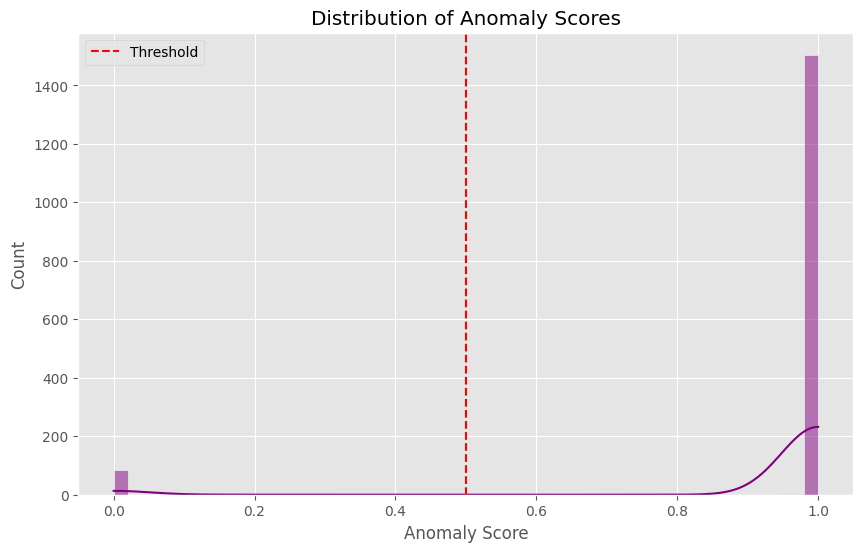


Sample Predictions:


,True Label,Predicted Label,Anomaly Score
0,1,True,0.999863
1,1,True,0.999983
2,1,True,0.999985
3,1,True,0.999132
4,1,True,0.999901
5,1,True,0.999980
6,1,True,0.999605
7,1,True,0.999995
8,1,True,0.999759
9,1,True,0.999932


In [15]:

def detect_anomalies(model, data, threshold=0.5):
    predictions = model.predict(data)
    anomaly_scores = predictions[:, 1]  # Probability of being an anomaly
    anomalies = anomaly_scores > threshold
    return anomalies, anomaly_scores

anomalies, scores = detect_anomalies(best_model, X_test)

# Plot anomaly scores distribution
plt.figure(figsize=(10, 6))
sns.histplot(scores, bins=50, kde=True, color='purple')
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')
plt.title('Distribution of Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Count')
plt.legend()
plt.show()

# Sample predictions
sample_results = pd.DataFrame({
    'True Label': y_true[:20],
    'Predicted Label': anomalies[:20],
    'Anomaly Score': scores[:20]
})
print("\nSample Predictions:")
display(sample_results)

# Cell 9: Attention Visualization and Feature Importance Analysis

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 10, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


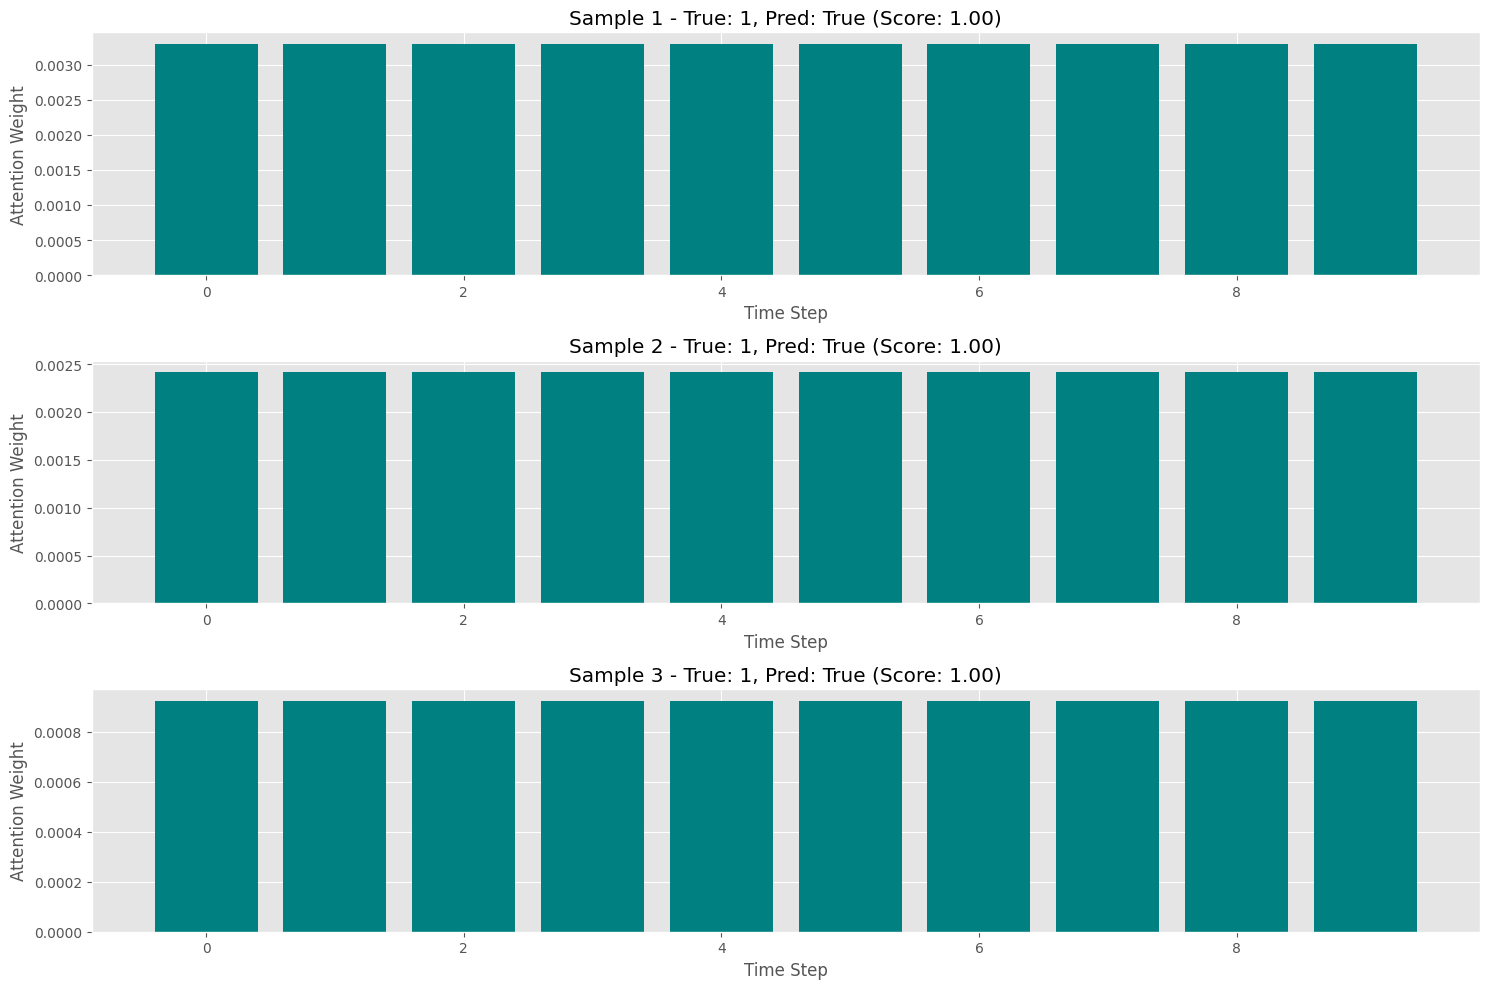


Attention weights shape: (10, 128)
Number of features: 17

Error: Dimension mismatch - Features: 17, Attention: 128
Possible solutions:
1. Check if 'features' list matches your input data
2. Try transposing attention weights (avg_attention.T)
3. Verify your attention layer implementation

Attention stats:
Min: -0.3217
Max: 0.3917
Mean: 0.0022


In [16]:

# Create attention model
attention_model = Model(
    inputs=encoder_inputs,
    outputs=[output, attention]
)

# ------------------------------------------------------------
# Part 1: Visualize attention weights for sample sequences
# ------------------------------------------------------------
sample_indices = np.random.choice(len(X_test), 3, replace=False)

plt.figure(figsize=(15, 10))
for i, idx in enumerate(sample_indices):
    sample_input = X_test[idx:idx+1]
    prediction, attention_weights = attention_model.predict(sample_input, verbose=0)

    # Reshape attention weights (handling potential shape issues)
    if attention_weights.ndim == 3:
        time_step_attention = np.mean(attention_weights[0], axis=-1)  # Average across features
    else:
        time_step_attention = attention_weights[0]  # Use as-is if already 1D

    plt.subplot(3, 1, i+1)
    plt.bar(range(len(time_step_attention)), time_step_attention, color='teal')
    plt.title(f'Sample {i+1} - True: {y_true[idx]}, Pred: {anomalies[idx]} (Score: {scores[idx]:.2f})')
    plt.xlabel('Time Step')
    plt.ylabel('Attention Weight')

plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Part 2: Feature Importance Analysis
# ------------------------------------------------------------
# Get attention weights for 100 samples (or adjust as needed)
n_samples = min(100, len(X_test))
avg_attention = np.mean([attention_model.predict(X_test[i:i+1], verbose=0)[1][0] for i in range(n_samples)], axis=0)

# Debugging information
print("\nAttention weights shape:", avg_attention.shape)
print("Number of features:", len(features))

# Handle different attention weight shapes
if avg_attention.ndim == 2:
    if avg_attention.shape[0] == len(features):  # [features, time]
        feature_importance = np.mean(avg_attention, axis=1)
    elif avg_attention.shape[1] == len(features):  # [time, features]
        feature_importance = np.mean(avg_attention, axis=0)
    else:
        print(f"Warning: Unexpected attention shape {avg_attention.shape}")
        feature_importance = np.mean(avg_attention, axis=0)
else:
    feature_importance = avg_attention  # Use as-is if already 1D

# Create and plot feature importance
if len(features) == len(feature_importance):
    feature_attention = pd.DataFrame({
        'Feature': features,
        'Attention': feature_importance
    }).sort_values('Attention', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Attention', y='Feature', data=feature_attention, palette='viridis')
    plt.title(f'Feature Importance Based on Attention (Averaged over {n_samples} samples)')
    plt.tight_layout()
    plt.show()
else:
    print(f"\nError: Dimension mismatch - Features: {len(features)}, Attention: {len(feature_importance)}")
    print("Possible solutions:")
    print("1. Check if 'features' list matches your input data")
    print("2. Try transposing attention weights (avg_attention.T)")
    print("3. Verify your attention layer implementation")

    # Show raw attention stats for debugging
    print("\nAttention stats:")
    print(f"Min: {np.min(avg_attention):.4f}")
    print(f"Max: {np.max(avg_attention):.4f}")
    print(f"Mean: {np.mean(avg_attention):.4f}")

# Cell 10: Threshold Analysis

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

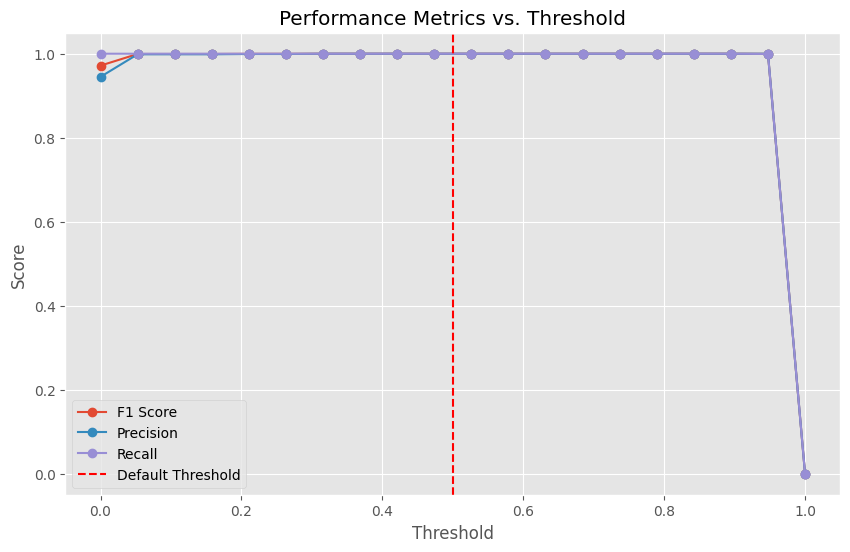

In [17]:

thresholds = np.linspace(0, 1, 20)
f1_scores = []
precisions = []
recalls = []

for thresh in thresholds:
    anomalies = y_pred[:, 1] > thresh
    report = classification_report(y_true, anomalies, output_dict=True)
    f1_scores.append(report['1']['f1-score'])
    precisions.append(report['1']['precision'])
    recalls.append(report['1']['recall'])

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score', marker='o')
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='o')
plt.axvline(x=0.5, color='red', linestyle='--', label='Default Threshold')
plt.title('Performance Metrics vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()